In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
from sklearn.preprocessing import *
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

sys.path.append("/home/shihab/repo/src")
from analysis_utils import convert_to_tensors, shuffle_and_split

torch.manual_seed(411)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## 3body

Oct 02


In [2]:
root = "../data/3b_cross"
times = os.listdir(root)
xs, ys = [], []
for f in times:  #This is buggy, I am loading data twice right?
    file = f[1:]
    x = np.load(f"{root}/X{file}")
    y = np.load(f"{root}/Y{file}")
    xs.append(x)
    ys.append(y)

X = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)

XY = np.hstack([X, Y])          # shape: (total_rows, 16)
print(XY.shape)

column_names = [
    # X columns 
    "x_s", "y_s", "z_s", "dist_s", "min_dist_s",
    "f_x_s", "f_y_s", "f_z_s",
    "tor_x_s", "tor_y_s", "tor_z_s",
    
    "x_k", "y_k", "z_k", "dist_k", "min_dist_k",
    # Y columns
    "vel_x", "vel_y", "vel_z",
    "angvel_x", "angvel_y", "angvel_z"
]

df = pd.DataFrame(XY, columns=column_names)
df.shape, df.columns

(40000, 22)


((40000, 22),
 Index(['x_s', 'y_s', 'z_s', 'dist_s', 'min_dist_s', 'f_x_s', 'f_y_s', 'f_z_s',
        'tor_x_s', 'tor_y_s', 'tor_z_s', 'x_k', 'y_k', 'z_k', 'dist_k',
        'min_dist_k', 'vel_x', 'vel_y', 'vel_z', 'angvel_x', 'angvel_y',
        'angvel_z'],
       dtype='object'))

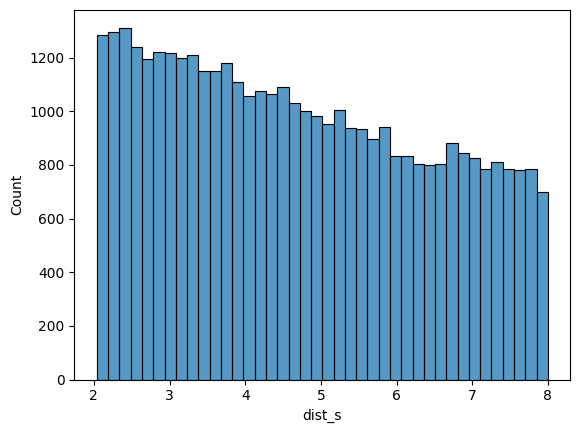

In [3]:
sns.histplot(df["dist_s"], bins=40);

In [4]:
df['dist_sk'] = np.sqrt(
    (df['x_s'] - df['x_k'])**2 +
    (df['y_s'] - df['y_k'])**2 +
    (df['z_s'] - df['z_k'])**2
)

# center all distance columns
mean_dist_s = df['dist_s'].mean()
mean_dist_k = df['dist_k'].mean()
mean_dist_sk = df['dist_sk'].mean()
print("Distance means:", mean_dist_s, mean_dist_k, mean_dist_sk)

df['dist_s'] -= mean_dist_s
df['dist_k'] -= mean_dist_k
df['dist_sk'] -= mean_dist_sk

df['dist_s_sq'] = df['dist_s']**2
df['dist_k_sq'] = df['dist_k']**2
df['dist_sk_sq'] = df['dist_sk']**2

df['dist_s_sqsq'] = df['dist_s_sq']**2
df['dist_k_sqsq'] = df['dist_k_sq']**2
df['dist_sk_sqsq'] = df['dist_sk_sq']**2

# Convert all actual position columns to relative positions
origin = np.array([0.0, 0.0, 0.0]) #target is at origin

# dvec = target-source
df['x_s'] = origin[0] - df['x_s']
df['y_s'] = origin[1] - df['y_s']
df['z_s'] = origin[2] - df['z_s']
df['x_k'] = origin[0] - df['x_k']
df['y_k'] = origin[1] - df['y_k']
df['z_k'] = origin[2] - df['z_k']

df.shape, df.columns

Distance means: 4.724224262198524 4.701194833185605 6.676046130020521


((40000, 29),
 Index(['x_s', 'y_s', 'z_s', 'dist_s', 'min_dist_s', 'f_x_s', 'f_y_s', 'f_z_s',
        'tor_x_s', 'tor_y_s', 'tor_z_s', 'x_k', 'y_k', 'z_k', 'dist_k',
        'min_dist_k', 'vel_x', 'vel_y', 'vel_z', 'angvel_x', 'angvel_y',
        'angvel_z', 'dist_sk', 'dist_s_sq', 'dist_k_sq', 'dist_sk_sq',
        'dist_s_sqsq', 'dist_k_sqsq', 'dist_sk_sqsq'],
       dtype='object'))

In [5]:
def prepare_vectors(df):
    force_cols = [
        'f_x_s', 'f_y_s', 'f_z_s', 'tor_x_s', 'tor_y_s', 'tor_z_s'    ]
    output_cols = [
        'vel_x', 'vel_y', 'vel_z',
        'angvel_x', 'angvel_y', 'angvel_z'
    ]
    dvec_s = ['x_s', 'y_s', 'z_s']
    feat_2b_s = ['dist_s', 'dist_s_sq', 'dist_s_sqsq', 'min_dist_s']
    dvec_k = ['x_k', 'y_k', 'z_k']
    feat_2b_k = ['dist_k', 'dist_k_sq', 'dist_k_sqsq', 'min_dist_k']
    sk_feats = ['dist_sk', 'dist_sk_sq', 'dist_sk_sqsq']

    feature_cols = dvec_s + dvec_k + feat_2b_s + feat_2b_k + sk_feats
    print("Using features:", feature_cols)
    
    dist_vec   = df[feature_cols].values
    force_vec  = df[force_cols].values
    output_vec = df[output_cols].values
    return dist_vec, force_vec, output_vec

In [6]:
feat, force, vel = prepare_vectors(df)
feat, force, vel = convert_to_tensors(feat, force, vel)


tmp = list(shuffle_and_split(df, feat, force, vel, split_frac=.8))
indices = tmp.pop()

for i in range(len(tmp)):
    tmp[i] = tmp[i].to(device)

(train_dist_tensor, val_dist_tensor, 
    train_force_tensor, val_force_tensor, 
    train_velocity_tensor, val_velocity_tensor) = tmp

train_dist_tensor.shape, train_force_tensor.shape, val_dist_tensor.shape

Using features: ['x_s', 'y_s', 'z_s', 'x_k', 'y_k', 'z_k', 'dist_s', 'dist_s_sq', 'dist_s_sqsq', 'min_dist_s', 'dist_k', 'dist_k_sq', 'dist_k_sqsq', 'min_dist_k', 'dist_sk', 'dist_sk_sq', 'dist_sk_sqsq']


(torch.Size([32000, 17]), torch.Size([32000, 6]), torch.Size([8000, 17]))

In [7]:
train_dist_tensor[:,-1].max()

tensor(6324.0659, device='cuda:0')

In [8]:
viscosity = 1.0
eigens = None

def outer(u):                        
    return torch.einsum('bi,bj->bij', u, u)

def sym(u, v):                        
    return 0.5*(torch.einsum('bi,bj->bij', u, v) +
                torch.einsum('bi,bj->bij', v, u))

def cross_mat(u):                     # [u]×
    levi = torch.tensor([[[0,0,0],[0,0,1],[0,-1,0]],
                         [[0,0,-1],[0,0,0],[1,0,0]],
                         [[0,1,0],[-1,0,0],[0,0,0]]],
                        dtype=u.dtype, device=u.device)
    return torch.einsum('ijk,bk->bij', levi, u)

def triplet_basis(r12, r13):          # r12 = x2–x1 , r13 = x3–x1
    e = r12 / r12.norm(p=2, dim=1, keepdim=True)
    f = r13 / r13.norm(p=2, dim=1, keepdim=True)
    I  = torch.eye(3, device=e.device).expand(len(e),3,3)
    B  = {                          # six independent pieces
        'I' : I,        'ee': outer(e),
        'ff': outer(f), 'ef': sym(e,f),
        'Xe': cross_mat(e), 'Xf': cross_mat(f)
    }
    return B

def triplet_block(r12, r13, coeff):
    B = triplet_basis(r12, r13)

    TT = (coeff[:,0,None,None]*B['I']  + coeff[:,1,None,None]*B['ee']
        + coeff[:,2,None,None]*B['ff'] + coeff[:,3,None,None]*B['ef'])
    RT = (coeff[:,4,None,None]*B['Xe'] + coeff[:,5,None,None]*B['Xf'])
    RR = (coeff[:,6,None,None]*B['I']  + coeff[:,7,None,None]*B['ee']
        + coeff[:,8,None,None]*B['ff'] + coeff[:,9,None,None]*B['ef'])

    K   = torch.zeros(len(r12),6,6, device=r12.device)
    K[:,:3,:3] = TT           # TT block
    K[:,3:,:3] = RT           # RT block
    K[:,:3,3:] = RT           # TR ≡ RT for identical spheres
    K[:,3:,3:] = RR           # RR block
    return K                 # shape [batch,6,6]


def velocity_triplet(r12, r13, coeff, force_s):
    K   = triplet_block(r12, r13, coeff)      # [B,6,6]
    v  = torch.einsum('bij,bj->bi', K, force_s)   # [B,6]

    return v

class ThreeBodyNet(nn.Module):
    """
    Predicts the 10 scalar functions (4 TT + 2 RT + 4 RR) that
    feed triplet_block / velocity_triplet.
    """
    def __init__(self, input_dim, two_nn_path, median_2b, mean_dist_s):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.SiLU(),
            nn.Linear(64, 128),
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, 128),
            nn.SiLU(),
            nn.Linear(128, 10)
        )
        self.two_nn = torch.jit.load(two_nn_path, map_location=device).eval()
        self.median_2b = median_2b
        self.mean_dist_s = mean_dist_s

    def forward(self, X):
        return self.net(X)           # shape [B,10]

    @torch.jit.export
    def predict_velocity(self, X, force_s):
        """
        Using features: ['x_s', 'y_s', 'z_s', 'x_k', 'y_k', 'z_k', 
        'dist_s', 'dist_s_sq', 'dist_s_sqsq', 'min_dist_s', 
        'dist_k', 'dist_k_sq', 'dist_k_sqsq', 'min_dist_k',
        'dist_sk', 'dist_sk_sq', 'dist_sk_sqsq']
        """
        coeff = self.forward(X[:,6:])               # [B,10]

        r12 = X[:, 0:3]                             # c2_x,y,z
        r13 = X[:, 3:6]                             # c3_x,y,z

        vel = velocity_triplet(r12, r13, coeff, force_s)
        return vel

    def predict_velocity_total(self, X3b, force_s, mu=1.0):
        return self.predict_two_body_from_triplet(X3b, force_s, mu) + \
               self.predict_velocity(X3b, force_s)
    
    def predict_two_body_from_triplet(self, X3b, force_s, mu=1.0):
        """
        X3b: [B, 17] triplet features in notebook order
        force_s: [B, 6] source force/torque in the lab frame (only s is nonzero)
        Returns: [B, 6] predicted two-body velocity on t due to s only
        """
        # Extract dvec_s = (x_s, y_s, z_s) which is target - source (already in lab frame)
        dvec_s = X3b[:, 0:3]                         # [B,3]

        # Recover raw dist_s: centered + mean
        dist_s_centered = X3b[:, 6]                  # [B]
        dist_s_raw = dist_s_centered + self.mean_dist_s

        # Build 2-body inputs
        min_dist_raw = dist_s_raw - 2.0              # [B]
        r2 = (dist_s_raw - self.median_2b)**2
        r4 = r2 * r2

        X2b = torch.cat(
            [dvec_s,
             dist_s_raw.unsqueeze(1),
             r2.unsqueeze(1),
             r4.unsqueeze(1),
             min_dist_raw.unsqueeze(1)],
            dim=1
        ).to(device)                                    # [B, 7] (sphere case)

        # Forces: only source on (s) is nonzero; target (t) = zeros
        Fs_target = torch.zeros_like(force_s, device=device)  # [B,6]
        Ft_source = force_s.to(device)                        # [B,6]

        mu_tensor = torch.tensor(float(mu), dtype=torch.float32, device=device)
        v2b = self.two_nn.predict_velocity(X2b, Fs_target, Ft_source, mu_tensor)  # [B,6]
        return v2b

    def make_residual_labels(self, X3b, force_s, y_total_3b, mu=1.0):
        """
        y_total_3b: [B,6] ground truth velocity on t from 3-body solve (s active, k passive)
        Returns residual labels: y_res = y_total_3b - v2b_pred
        """
        v2b = self.predict_two_body_from_triplet(X3b, force_s, mu)
        return y_total_3b.to(device) - v2b

In [9]:
# viscosity = 1.0
# eigens = None

# class ThreeBodyNet(nn.Module):
#     def __init__(self, input_dim, two_nn_path, median_2b, mean_dist_s):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.Tanh(),
#             nn.Linear(64, 128),
#             nn.Tanh(),
#             nn.Linear(128, 256),
#             nn.Tanh(),
#             nn.Linear(256, 128),
#             nn.Tanh(),
#             nn.Linear(128, 36)
#         )
#         self.two_nn = torch.jit.load(two_nn_path, map_location=device).eval()
#         self.median_2b = median_2b
#         self.mean_dist_s = mean_dist_s
        
#     def forward(self, X):
#         return self.net(X)           # shape [B,10]

#     @torch.jit.export
#     def predict_velocity(self, X, force_s):
#         coeff = self.forward(X)                     # [B,10]

#         M_3b = torch.reshape(coeff, (-1, 6, 6))
#         v = torch.bmm(M_3b, force_s.unsqueeze(-1)).squeeze(-1)
#         return v

#     def predict_velocity_total(self, X3b, force_s, mu=1.0):
#         return self.predict_two_body_from_triplet(X3b, force_s, mu) + \
#                self.predict_velocity(X3b, force_s)
        

#     def predict_two_body_from_triplet(self, X3b, force_s, mu=1.0):
#         """
#         X3b: [B, 17] triplet features in notebook order
#         force_s: [B, 6] source force/torque in the lab frame (only s is nonzero)
#         Returns: [B, 6] predicted two-body velocity on t due to s only
#         """
#         # Extract dvec_s = (x_s, y_s, z_s) which is target - source (already in lab frame)
#         dvec_s = X3b[:, 0:3]                         # [B,3]

#         # Recover raw dist_s: centered + mean
#         dist_s_centered = X3b[:, 6]                  # [B]
#         dist_s_raw = dist_s_centered + self.mean_dist_s

#         # Build 2-body inputs
#         min_dist_raw = dist_s_raw - 2.0              # [B]
#         r2 = (dist_s_raw - self.median_2b)**2
#         r4 = r2 * r2

#         X2b = torch.cat(
#             [dvec_s,
#              dist_s_raw.unsqueeze(1),
#              r2.unsqueeze(1),
#              r4.unsqueeze(1),
#              min_dist_raw.unsqueeze(1)],
#             dim=1
#         ).to(device)                                    # [B, 7] (sphere case)

#         # Forces: only source on (s) is nonzero; target (t) = zeros
#         Fs_target = torch.zeros_like(force_s, device=device)  # [B,6]
#         Ft_source = force_s.to(device)                        # [B,6]

#         mu_tensor = torch.tensor(float(mu), dtype=torch.float32, device=device)
#         v2b = self.two_nn.predict_velocity(X2b, Fs_target, Ft_source, mu_tensor)  # [B,6]
#         return v2b

#     def make_residual_labels(self, X3b, force_s, y_total_3b, mu=1.0):
#         """
#         y_total_3b: [B,6] ground truth velocity on t from 3-body solve (s active, k passive)
#         Returns residual labels: y_res = y_total_3b - v2b_pred
#         """
#         v2b = self.predict_two_body_from_triplet(X3b, force_s, mu)
#         return y_total_3b.to(device) - v2b

## Modelling

In [10]:
input_dim = train_dist_tensor.shape[1] - 6
batch_size = 256
epochs = 350 #350 seemed important for mob_op_3b acc on reference.csv

twob_path = "../data/models/two_body_combined_model.pt"
median_2b = 5.008307682776568 #copied from 2b training notebook
model = ThreeBodyNet(input_dim, twob_path,median_2b, mean_dist_s).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


criterion = nn.MSELoss()
#criterion = nn.L1Loss()
n_batches = train_velocity_tensor.shape[0]//batch_size
n_batches, n_batches*batch_size, len(train_dist_tensor)

(125, 32000, 32000)

In [11]:
def shuffle_tensors(*tensors):
    """ Shuffles multiple tensors in the same order """
    indices = torch.randperm(tensors[0].size(0),device=device)  # Generate random indices
    return tuple(tensor[indices] for tensor in tensors)

with torch.no_grad():
    y_residual = model.make_residual_labels(
        train_dist_tensor, 
        train_force_tensor, 
        train_velocity_tensor, mu=1.0)

In [12]:
y_residual[:10]

tensor([[ 0.0304,  0.0655, -0.1373, -0.0009, -0.0041,  0.0122],
        [ 0.1231, -0.0318,  0.1026,  0.0157,  0.1389,  0.0258],
        [-0.0023, -0.0237,  0.0061, -0.0144,  0.0013,  0.0186],
        [ 0.1129, -0.0677, -0.2372, -0.1318, -0.0899,  0.1440],
        [ 0.0070,  0.0123, -0.0324, -0.0159, -0.0121,  0.0235],
        [-0.0270,  0.0014,  0.0003,  0.0058, -0.0241, -0.0122],
        [-0.0100,  0.0122,  0.0210,  0.0033, -0.0067,  0.0202],
        [-0.1262,  0.0534, -0.1841,  0.0878, -0.0363,  0.1270],
        [-0.0192, -0.0019, -0.0218, -0.0047, -0.0002, -0.0230],
        [-0.0381,  0.0993,  0.0641, -0.0373, -0.0543, -0.0827]],
       device='cuda:0')

In [13]:
    
losses = []
data_losses, spsd_losses = [], []
for epoch in range(epochs):
    model.train()
    avg = 0
    avg_data, avg_spsd = 0, 0
    
    train_dist_tensor, train_force_tensor, y_residual = shuffle_tensors(
        train_dist_tensor, train_force_tensor, y_residual
    )
    for it in range(n_batches):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        
        X = train_dist_tensor[indices]  
        force_s = train_force_tensor[indices]         
        Y = y_residual[indices]  

        Y_b = model.predict_velocity(X, force_s)
        loss = criterion(Y_b, Y)
        
        loss.backward()
        avg += loss.item()
        avg_data += 0 #data_loss.item()
        #avg_spsd += spsd_loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_batches}')
        losses.append(avg/n_batches)
        data_losses.append(avg_data/n_batches)
        spsd_losses.append(avg_spsd/n_batches)

torch.save(model.state_dict(), "3body_cross.wt")

Epoch 0, Loss: 18.391458940565585
Epoch 5, Loss: 0.014291013695299625
Epoch 10, Loss: 0.0061415061429142956
Epoch 15, Loss: 0.813024499874562
Epoch 20, Loss: 0.0009841135181486607
Epoch 25, Loss: 0.0005443476310465485
Epoch 30, Loss: 0.0003588459399761632
Epoch 35, Loss: 0.00023463746812194585
Epoch 40, Loss: 0.0003001593197695911
Epoch 45, Loss: 0.00012746003997744993
Epoch 50, Loss: 9.639379201689735e-05
Epoch 55, Loss: 0.000280547684407793
Epoch 60, Loss: 8.814805478323251e-05
Epoch 65, Loss: 5.668062638142146e-05
Epoch 70, Loss: 4.740045095968526e-05
Epoch 75, Loss: 0.00012774240950238892
Epoch 80, Loss: 5.6763705069897694e-05
Epoch 85, Loss: 5.269880779087543e-05
Epoch 90, Loss: 2.5864422641461716e-05
Epoch 95, Loss: 7.505397738714237e-05
Epoch 100, Loss: 5.5740224197506905e-05
Epoch 105, Loss: 5.170002943486907e-05
Epoch 110, Loss: 3.539435578568373e-05
Epoch 115, Loss: 3.054483829328092e-05
Epoch 120, Loss: 3.743847660371102e-05
Epoch 125, Loss: 4.6944826615799684e-05
Epoch 130,

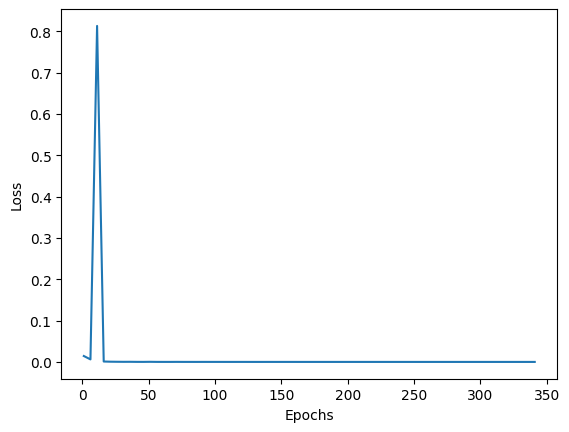

In [14]:
import matplotlib.pyplot as plt
los = losses[1:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los);
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.savefig("loss.png");

## Evaluation

In [15]:
model = ThreeBodyNet(input_dim, twob_path,median_2b, mean_dist_s).to(device)
model.load_state_dict(torch.load("3body_cross.wt", weights_only=True))
model.eval()

with torch.no_grad():
    val_output = model.predict_velocity_total(val_dist_tensor, val_force_tensor)

In [16]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 185
val_output[jj], val_velocity_tensor[jj], val_dist_tensor[jj, [6,10,14]]

(tensor([-0.110665,  0.234305, -0.272255,  0.003983,  0.034451,  0.029250],
        device='cuda:0'),
 tensor([-0.109013,  0.234673, -0.274385,  0.002120,  0.036132,  0.035760],
        device='cuda:0'),
 tensor([-1.258089, -2.584173, -1.851157], device='cuda:0'))

In [17]:
criterion = nn.MSELoss(reduction='none') 
err = criterion(val_output, val_velocity_tensor)

rmse = torch.sqrt(err.mean(axis=0))

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(val_velocity_tensor).mean(axis=0))
print("RMSE:", err.mean()**.5)

Root Mean Squared error for each of 6 output variables:
 tensor([0.002345, 0.002796, 0.002556, 0.001463, 0.001423, 0.001460],
       device='cuda:0')
Actual Magnitude:
  tensor([0.128210, 0.127427, 0.125916, 0.021024, 0.021028, 0.021496],
       device='cuda:0')
RMSE: tensor(0.002088, device='cuda:0')


In [18]:
#### Mean Relative Absolute Error
valid_mask = torch.abs(val_velocity_tensor) > 1e-6

filtered_y_tensor = torch.where(valid_mask, val_velocity_tensor, torch.tensor(float('nan')))
relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)

a,_ = torch.nanmedian(relative_error, dim=0)
a*100

tensor([0.524537, 0.531891, 0.531882, 2.990605, 3.023539, 3.013410],
       device='cuda:0')

In [19]:
a = torch.nanmean(relative_error, dim=0)
a*100

tensor([ 4.033917,  6.146086,  4.232626, 25.827269, 19.724447, 36.014763],
       device='cuda:0')

In [20]:
100*rmse/torch.abs(val_velocity_tensor).mean(axis=0)

tensor([1.829061, 2.194143, 2.030095, 6.960518, 6.767957, 6.794086],
       device='cuda:0')

In [21]:
# scripted_model = torch.jit.script(model)
# scripted_model.save("../data/models/3body_cross.pt")

# Finetuning didn't work
# ft_2b_path = "../data/models/two_body_combined_model_finetuned.pt"
# model.two_nn.eval()  # optional, but recommended
# model.two_nn.save(ft_2b_path)


In [30]:
# Comparing w/ multibody
metric = []
dsss = []
dttt = []
for i in range(len(df)):
    row = df.iloc[i].values
    d_ks = np.linalg.norm(row[0:3]-row[11:14])
    d_kt = np.linalg.norm(row[11:14])
    metric.append(d_kt*d_ks)
    dsss.append(d_ks)
    dttt.append(d_kt)
    
(
    sum(metric)/len(metric),
    sum(dsss)/len(dsss),
    sum(dttt)/len(dttt)
)

(33.20564231536785, 6.676046130020485, 4.701194833185608)

In [32]:
np.median(dsss), np.median(dttt)

(6.484691125608878, 4.558643371662552)

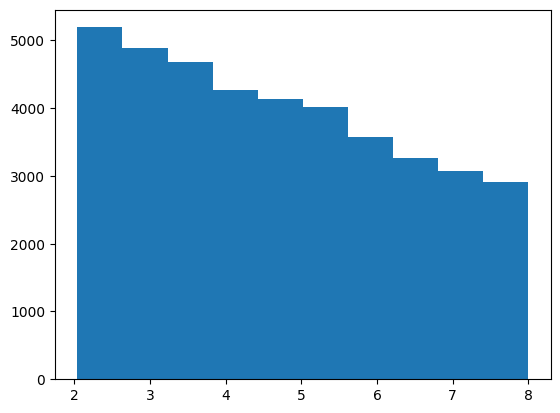

In [33]:
plt.hist(dttt);